In [1]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, HTML


<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>

In [2]:
# data downloaded from NASA:
# https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# and stored in directory cmapsdata

#bunch of setup
%matplotlib inline
sns.set()
inputdir = "cmapsdata" 

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [3]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'/train_FD001.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'/test_FD001.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Computing RUL and flagging all failure cases in the training set

In [4]:
#count cycle time
df_train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle = df_train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

# merge the max cycle back into the original frame
train_merged = df_train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

# calculate RUL for each row
Target_RUL = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_RUL"] = Target_RUL

# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

# flag failures
train_with_target["IsFailure"] = train_with_target['Target_RUL'] == 0

#show the table
display(train_with_target)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_RUL,IsFailure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,False
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,False
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,False
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,False
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,False
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,False
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,False
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,False


We can now easily collect the features of failure cases in the training set

In [5]:
display(train_with_target[train_with_target['IsFailure'] == True])

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_RUL,IsFailure
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0,True
478,2,287,-0.0005,0.0006,100.0,518.67,643.85,1608.50,1430.84,14.62,...,8175.57,8.5365,0.03,398,2388,100.0,38.43,23.0848,0,True
657,3,179,0.0012,0.0000,100.0,518.67,643.51,1604.80,1428.23,14.62,...,8255.34,8.5056,0.03,398,2388,100.0,38.40,22.9562,0,True
846,4,189,-0.0024,-0.0002,100.0,518.67,644.53,1612.11,1432.55,14.62,...,8259.42,8.5246,0.03,398,2388,100.0,38.44,23.1006,0,True
1115,5,269,0.0022,0.0003,100.0,518.67,643.46,1597.28,1430.74,14.62,...,8212.75,8.5209,0.03,397,2388,100.0,38.45,23.0296,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19887,96,336,-0.0031,-0.0005,100.0,518.67,643.74,1599.20,1432.12,14.62,...,8144.03,8.5022,0.03,397,2388,100.0,38.36,23.0258,0,True
20089,97,202,0.0014,0.0001,100.0,518.67,643.79,1610.66,1427.41,14.62,...,8263.63,8.5277,0.03,397,2388,100.0,38.29,23.1184,0,True
20245,98,156,0.0077,-0.0003,100.0,518.67,643.02,1603.77,1432.16,14.62,...,8122.22,8.5308,0.03,396,2388,100.0,38.33,23.1137,0,True
20430,99,185,-0.0019,-0.0004,100.0,518.67,643.93,1598.42,1421.56,14.62,...,8127.53,8.5425,0.03,397,2388,100.0,38.49,23.1931,0,True


Let's first visualize failure and non-failure cases. 

We will use PCA to reduce the dimension and then plot the failure cases, which shall help in the future path of this study.

In [6]:
#let's build feature set X and label Y
to_drop = ['UnitNumber', 'Cycle', 'Target_RUL', 'IsFailure']  
X = train_with_target.drop(to_drop, axis = 1)
Y = train_with_target['IsFailure']

# Dimensionality Reduction with PCA

Let's try PCA with 10 components just to see how much variance we can capture. First we fit the feature data

In [7]:
pca_comp = 10
pca = PCA(n_components=pca_comp)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

... then let's see the variance explained.

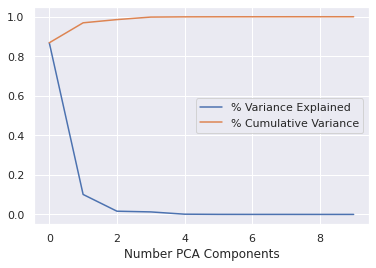

In [8]:
pca_var = pca.explained_variance_/pca.explained_variance_.sum()
pca_cumsum = pca_var.cumsum()

plt.plot(np.arange(pca_comp), pca_var, label="% Variance Explained")
plt.plot(np.arange(pca_comp), pca_cumsum, label="% Cumulative Variance")
plt.xlabel("Number PCA Components")
plt.legend()
plt.show()

Quite good. Let us much reduced dimension for visualization purposes.
Let us use PCA with `n_comp = 2`, transform the feature, and plot with the label.

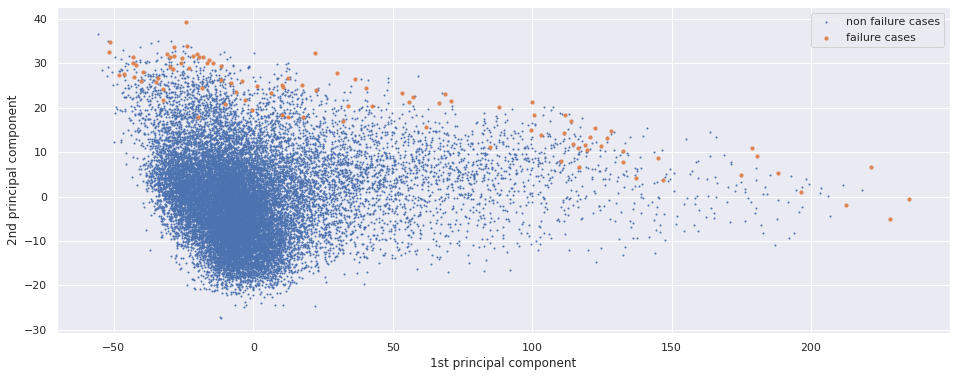

In [9]:
#fit PCA with 2 components
pca_comp = 2
pca = PCA(n_components=pca_comp)
pca.fit(X)

#transform feature with this model
X_pca = pca.transform(X)

#distinguish features based on label
X_failures = X_pca[Y, :]
X_nonfailures = X_pca[~Y, :]

#plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(X_nonfailures[:,0], X_nonfailures[:,1], s=1, label="non failure cases")
ax.scatter(X_failures[:,0], X_failures[:,1], s=10, label="failure cases")
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.legend()
plt.show()

Not bad, the failure cases seems to have some sort of pattern in this two dimensional principal component space. 
What's next?

---

Think of ways to extract the trend for machine and trying to predict the probability of failure, given a set of feature (hint: classification algorithm). 

Another way to approach this is to try to predict what is the RUL, given a set of feature (hint: regression. see e.g. [Kaggle](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot/)).

Note: We have not implemented any time series analyses yet. We can do that, in fact, that might be a superior approach. We can first extract the trend while also analysing the variance. Then our goal might be to predict what is the optimal predictive maintenance strategy (optimal in the sense it balances risk and maintenance cost, or something like that). Cheers!